# Loading data

In [6]:
import torch
import pandas as pd

In [13]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 4.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.9/930.9 KB 5.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:00m eta 0:00:010:01:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [68]:
# import required libraries
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

# Read H5 file
f = h5.File("core_test.hdf", "r")
# Get and print list of datasets within the H5 file
datasetNames = [n for n in f.keys()]
data = f.values()

In [69]:
len(datasetNames)

290

In [90]:
mlhdf_ds = f[datasetNames[0]]['pybel']['processed']
actual_data = mlhdf_ds["data"][:]

NameError: name 'f' is not defined

In [ ]:
parser.add_argument("--data-dir", default="/home/kim63/data", help="dataset directory")
parser.add_argument("--mlhdf-fn", default="pdbbind2019_crystal_refined_ml.hdf", help="training ml-hdf path")
parser.add_argument("--dataset-type", type=float, default=1, help="ml-hdf version, (1: for fusion, 1.5: for cfusion 2: ml-hdf v2)")
parser.add_argument("--csv-fn", default="pdbbind2019_crystal_refined.csv", help="training csv file path")
parser.add_argument("--rmsd-weight", action='store_false', default=0, help="whether rmsd-based weighted loss is used or not")
parser.add_argument("--rmsd-threshold", type=float, default=2, help="rmsd cut-off threshold in case of docking data and/or --rmsd-weight is true")


In [62]:
from data_reader import Dataset_MLHDF
import os
args = {}
args['data_dir'] = './'
args['mlhdf_fn'] = 'core_test.hdf'
args['dataset_type'] = 1
args['csv_fn'] = 'pdbbind_2016_train_val_test.csv'
args['rmsd_weight'] = 0
args['rmsd_threshold'] = 2
#args = pd.DataFrame.from_dict(args,orient='index').T

In [63]:
dataset = Dataset_MLHDF(os.path.join(args['data_dir'], args['mlhdf_fn']), args['dataset_type'], os.path.join(args['data_dir'], args['csv_fn']), is_crystal=False, rmsd_weight=args['rmsd_weight'], rmsd_thres=args['rmsd_threshold'])

ValueError: could not convert string to float: '3zzf'

## Affinity data

In [33]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import random

In [9]:
# path to the extracted PDBbind dataset
path = './'

In [10]:
%%bash -s $path --out missing

path=$1

# Save binding affinities to csv file

echo 'pdbid,-logKd/Ki' > affinity_data.csv
cat $path/general-set-except-refined/index/INDEX_general_PL_data.2016 | while read l1 l2 l3 l4 l5; do
    if [[ ! $l1 =~ "#" ]]; then
        echo $l1,$l4
    fi
done >> affinity_data.csv


# Find affinities without structural data (i.e. with missing directories)

cut -f 1 -d ',' affinity_data.csv | tail -n +2 | while read l;
    do if [ ! -e $path/general-set-except-refined/$l ] &&  [ ! -e $path/refined-set/$l ]; then
        echo $l;
    fi
done

In [11]:
missing = set(missing.split())
len(missing)

1

In [12]:
affinity_data = pd.read_csv('affinity_data.csv', comment='#')
affinity_data = affinity_data[~np.in1d(affinity_data['pdbid'], list(missing))]
affinity_data.head()

,pdbid,-logKd/Ki
0,3zzf,0.40
1,3gww,0.45
2,1w8l,0.49
3,3fqa,0.49
4,1zsb,0.60


In [13]:
# Check for NaNs
affinity_data['-logKd/Ki'].isnull().any()

False

In [24]:
 # Separate core, refined, and general sets

#core_set = ! grep -v '#' $path/general-set-except-refined/index/INDEX_core_data.2016 | cut -f 1 -d ' '
core_set = set([ f.path[11:] for f in os.scandir('./core-set') if f.is_dir() ])#set(core_set)

refined_set = ! grep -v '#' $path/general-set-except-refined/index/INDEX_refined_data.2016 | cut -f 1 -d ' '
refined_set = set(refined_set)

general_set = set(affinity_data['pdbid'])


assert core_set & refined_set == core_set
assert refined_set & general_set == refined_set

len(general_set), len(refined_set), len(core_set)

(13307, 4057, 285)

In [25]:
affinity_data.loc[np.in1d(affinity_data['pdbid'], list(general_set)), 'set'] = 'general'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(refined_set)), 'set'] = 'refined'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(core_set)), 'set'] = 'core'

affinity_data.head()

,pdbid,-logKd/Ki,set
0,3zzf,0.40,general
1,3gww,0.45,general
2,1w8l,0.49,general
3,3fqa,0.49,general
4,1zsb,0.60,general


In [26]:
affinity_data.groupby('set').apply(len).loc[['general', 'refined', 'core']]

set
general    9250
refined    3772
core        285
dtype: int64

/home/vscode/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vscode/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vscode/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vscode/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: F

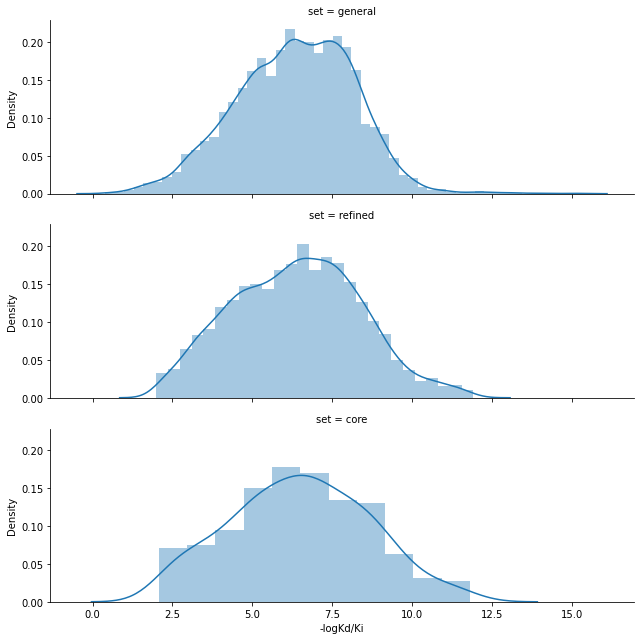

In [27]:
grid = sns.FacetGrid(affinity_data, row='set', row_order=['general', 'refined', 'core'],
                     size=3, aspect=3)
grid.map(sns.distplot, '-logKd/Ki');

In [34]:
affinity_data[['pdbid', '-logKd/Ki', 'set']].to_csv('../data/affinity_data_cleaned.csv', index=False)

In [87]:
affinity_data

,pdbid,-logKd/Ki,set
0,3zzf,0.40,general
1,3gww,0.45,general
2,1w8l,0.49,general
3,3fqa,0.49,general
4,1zsb,0.60,general
...,...,...,...
13302,7cpa,13.96,general
13303,2xuf,14.39,general
13304,1avd,15.00,general
13305,2xui,15.00,general


In [13]:
affinity_data = pd.read_csv('../data/affinity_data_cleaned.csv')
general = affinity_data[affinity_data.set=='general']
refined = affinity_data[affinity_data.set=='refined']
core = affinity_data[affinity_data.set=='core']

In [75]:
qs = np.quantile(general['-logKd/Ki'], np.arange(0,1.1,0.1))
qs[0]-=0.01
idxs_train = []
idxs_val = []
for i in range(len(qs)-1):
    q1 = qs[i]
    q2 = qs[i+1]
    gen_q = general[(general['-logKd/Ki']>q1) & (general['-logKd/Ki']<=q2)].index.values.tolist()
    size_train = int(0.9*len(gen_q))
    idx_train = random.sample(gen_q,size_train)
    idx_val = [idx for idx in gen_q if idx not in idx_train]
    idxs_train+=idx_train
    idxs_val+=idx_val
general_train = general.loc[idxs_train]
general_train.set = 'general_train'
general_val = general.loc[idxs_val]
general_val.set = 'general_val'

In [78]:
qs = np.quantile(refined['-logKd/Ki'], np.arange(0,1.1,0.1))
qs[0]-=0.01
idxs_train = []
idxs_val = []
for i in range(len(qs)-1):
    q1 = qs[i]
    q2 = qs[i+1]
    ref_q = refined[(refined['-logKd/Ki']>q1) & (refined['-logKd/Ki']<=q2)].index.values.tolist()
    size_train = int(0.9*len(ref_q))
    idx_train = random.sample(ref_q,size_train)
    idx_val = [idx for idx in ref_q if idx not in idx_train]
    idxs_train+=idx_train
    idxs_val+=idx_val
refined_train = refined.loc[idxs_train]
refined_train.set = 'refined_train'
refined_val = refined.loc[idxs_val]
refined_val.set = 'refined_val'

In [88]:
affinity_data = pd.concat([general_train, general_val, refined_train, refined_val, core])
affinity_data

,pdbid,-logKd/Ki,set
640,2ay6,3.11,general_train
1326,2ou7,3.81,general_train
720,1x6u,3.22,general_train
1191,1bcj,3.70,general_train
1123,3udj,3.62,general_train
...,...,...,...
13225,5dwr,11.22,core
13237,4f2w,11.30,core
13240,2x00,11.33,core
13268,3o9i,11.82,core


In [89]:
affinity_data.to_csv('../data/affinity_data_cleaned.csv', index=False)

## Move .mol2 files

In [4]:
path='ligand_mol2_files.csv'

In [6]:
path='pocket_mol2_files.csv'

In [7]:
%%bash -s $path
path=$1
cat $path | while read pdbfile; do
        #echo ${pdbfile}
        cp -R ${pdbfile} '../data/raw_data/'
done
echo "finished processing"

finished processing


In [8]:
9226 +  4057

13283